## Installing the required libraries

In [ ]:
!pip install --quiet nibabel simpleitk nilearn transformers vit-keras tensorflow-addons keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 118.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Downloading and processing the abide dataset using the nilearn library

In [ ]:
#!/usr/bin/env python

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from argparse import ArgumentParser
import numpy as np
from sklearn.decomposition import PCA
import os
import pandas as pd

def prepare_data(data_dir, output_dir, pipeline = "cpac", quality_checked = True):
    # get dataset
    print("Loading dataset...")
    abide = datasets.fetch_abide_pcp(data_dir = data_dir,
                                     pipeline = pipeline,
                                     n_subjects = 1,
                                     quality_checked = quality_checked)
    # make list of filenames
    fmri_filenames = abide.func_preproc

    # load atlas
    multiscale = datasets.fetch_atlas_basc_multiscale_2015()
    atlas_filename = multiscale.scale064

    # initialize masker object
    masker = NiftiLabelsMasker(labels_img=atlas_filename,
                               standardize=True,
                               memory='nilearn_cache',
                               verbose=0)

    # initialize correlation measure
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                             discard_diagonal=True)

    try: # check if feature file already exists
        # load features
        feat_file = os.path.join(output_dir, 'ABIDE_BASC064_features.npz')
        X_features = np.load(feat_file)['a']
        print("Feature file found.")

    except: # if not, extract features
        X_features = [] # To contain upper half of matrix as 1d array
        print("No feature file found. Extracting features...")

        for i,sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
            time_series = masker.fit_transform(sub)
            # create a region x region correlation matrix
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # add to our container
            X_features.append(correlation_matrix)
            # keep track of status
            print('finished extracting %s of %s'%(i+1,len(fmri_filenames)))
        # Save features
        np.savez_compressed(os.path.join(output_dir, 'ABIDE_BASC064_features'),
                                         a = X_features)

    # Dimensionality reduction of features with PCA
    # print("Running PCA...")
    # pca = PCA(0.99).fit(X_features) # keeping 99% of variance
    # X_features_pca = pca.transform(X_features)

    # Transform phenotypic data into dataframe
    abide_pheno = pd.DataFrame(abide.phenotypic)

    # Get the target vector
    y_target = abide_pheno['DX_GROUP']

    return(X_features, y_target)



/usr/local/lib/python3.10/dist-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [ ]:
#Import modules
import numpy as np
from sklearn.model_selection import GroupKFold
import os

#Define data and output directories
data_dir = 'data/'
output_dir = data_dir

X, y = prepare_data(data_dir,output_dir)

# logo = GroupKFold(n_splits=10)
# logo.get_n_splits(X, y, groups)

In [ ]:
np.save('x.npy',X)
np.save('y.npy',y)

In [ ]:
import numpy as np
X = np.load('x.npy')
y=np.load('y.npy')

In [ ]:
X= np.array(X)
y = np.array(y)

In [ ]:
X.shape,y.shape

((400, 2016), (400,))

In [ ]:
X = np.reshape(X,(X.shape[0],42,-1))
y=y-1

In [ ]:
b = np.zeros((y.size, int(y.max()) + 1))
b[np.arange(y.size), y.astype(np.uint)] = 1
b.shape

(400, 2)

In [ ]:
y=b
y.shape

(400, 2)

Making the dataset ready to be used for the model training

In [ ]:
Xx = np.stack([X,X,X],axis=3)
Xx = np.resize(Xx,(Xx.shape[0],224,224,3))
Xx.shape

(400, 224, 224, 3)

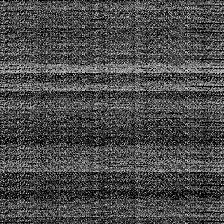

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(Xx[10]*255)

In [ ]:
import cv2
cv2.imwrite('test.jpg',Xx[0])

True

In [ ]:
np.save(Xx[0].shape)

(224, 224, 3)

## Building a teacher student model structure for the pretraining of the ViT model

In [ ]:
import tensorflow as tf
from keras_core import Model, Sequential
from keras_core.layers import Layer
import keras_core.layers as nn
import keras_core as keras

In [ ]:
from vit_keras import vit
vit_model = vit.vit_b32(
        image_size = (224,224),
        pretrained = True,
        include_top = True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
import tensorflow as tf
base_cnn = keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet',
)

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
def loss_fn(x, y):
    x =  keras.utils.normalize(x, axis=-1, order=2)
    y =  keras.utils.normalize(y, axis=-1, order=2)
    return 2 - 2 * tf.reduce_sum((x * y))

In [ ]:
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.Adam()

In [ ]:
import numpy as np
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(x, y):
    with tf.GradientTape(persistent=True) as tape:
        logits_cnn = base_cnn(x)
        logits_vit = vit_model(x)
        loss_value = loss_fn(logits_cnn, logits_vit)
    grads1 = tape.gradient(loss_value, base_cnn.trainable_weights)
    optimizer1.apply_gradients(zip(grads1, base_cnn.trainable_weights))
    grads2 = tape.gradient(loss_value, vit_model.trainable_weights)
    optimizer2.apply_gradients(zip(grads2, vit_model.trainable_weights))
    return loss_value

import time
train_loss_list=[]
epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    train_loss = []
    x_batch_train=[]
    y_batch_train=[]
    for step, (t, z) in enumerate(zip(Xx,y)):
        x_batch_train.append(t)
        y_batch_train.append(z)
        if len(x_batch_train)==32:
          loss_value = train_step(np.array(x_batch_train), np.array(y_batch_train))
          train_loss.append(float(loss_value))
          x_batch_train=[]
          y_batch_train=[]
          if step % 100 == 0:
              print(
                  "Training loss (for one batch) at step %d: %.4f"
                  % (step, float(loss_value))
              )



In [ ]:
loss_value

<tf.Tensor: shape=(), dtype=float32, numpy=-54.29072>

In [ ]:
model_cnn_sup = Sequential([
    base_cnn,
    nn.Dense(2,activation='softmax')
])

In [ ]:
!pip install --quiet focal-loss

## Fine-tuning the cnn and vit models using the Binary Focal loss

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
model_cnn_sup.compile(loss=BinaryFocalLoss(gamma=2),optimizer='adam',metrics='accuracy')

In [ ]:
model_cnn_sup.fit(Xx,y,epochs=5,verbose=1,batch_size=32)

In [ ]:
model_vit_sup = Sequential([
    vit_model,
    nn.Dense(2,activation='softmax')
])

In [ ]:
model_vit_sup.compile(loss=BinaryFocalLoss(gamma=2),optimizer='adam',metrics='accuracy')

In [ ]:
model_vit_sup.fit(Xx,y,epochs=5,verbose=1, batch_size=32)

In [ ]:
model_cnn_sup.save('cnn.keras')
model_vit_sup.save('vit.keras')

In [ ]:
import keras_core as keras
cnn = keras.saving.load_model('cnn.keras')

In [ ]:
import keras_core as keras
vit = keras.saving.load_model('vit.keras')

In [ ]:
cnn.predict(Xx)

In [ ]:
!pip install gradio

## generating the gradio demo for visualisation and hosting

In [ ]:
import gradio as gr
import tensorflow as tf
from keras_core import Model, Sequential
from keras_core.layers import Layer
import keras_core.layers as nn
import keras_core as keras
import numpy as np
# vit = keras.models.load_model('vit/')
# cnn = keras.models.load_model('cnn/')
def fn(image,model_t):
  if len(image.shape)==2:
    img = np.stack([image,image,image],axis=2)
    img = np.resize(img,(224,224,3))
  elif len(image.shape)==3 and image.shape[2]==1:
    img = np.stack([image[:,:,0],image[:,:,0],image[:,:,0]],axis=2)
    img = np.resize(img,(224,224,3))
  else:
    img = np.resize(image,(224,224,3))
  img = np.expand_dims(img,axis=0)
  if model_t=='vit':
    pred = vit.predict(img)
  else:
    pred= cnn.predict(img)
  if np.argmax(pred)==0:
    return 'autism'
  else:
    return 'control'


demo = gr.Interface(
    fn,['image',gr.Dropdown(
            ["resnet", "vit"], label="model")],"text",

)

if __name__ == "__main__":
    demo.launch()

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 345ms/step
Keyboard interruption in main thread... closing server.
